In [1]:
import pandas as pd, numpy as np, datetime as dt, re
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score,mean_absolute_error
import seaborn as sns
import pylab

In [2]:
df = pd.read_excel('data (2) (1) (1).xlsx', sheet_name='data')

## Data-Prep

In [3]:
def categorical_transform_all(data, trnsfrm_cols_like):
    all_d = pd.DataFrame()
    for trnsfrm_cols in trnsfrm_cols_like:
        columns_list = [j for j in data.columns if trnsfrm_cols in j]
        temp= pd.get_dummies(data[columns_list].stack(),prefix= trnsfrm_cols[19:]).groupby(level=0).max()
        all_d = pd.concat([all_d,temp],axis=1)
    return all_d

In [ ]:
comment_col = ['engineTransmission_battery_cc_value','engineTransmission_engineOil_cc_value',
      'engineTransmission_engine_cc_value','engineTransmission_coolant_cc_value',
      'engineTransmission_engineSound_cc_value','engineTransmission_clutch_cc_value',
      'engineTransmission_gearShifting_cc_value','engineTransmission_comments_value',
      'engineTransmission_engineOilLevelDipstick_cc_value','engineTransmission_engineMounting_cc_value',
      'engineTransmission_exhaustSmoke_cc_value','engineTransmission_engineBlowByBackCompression_cc_value',
      ]
train_categ = categorical_transform_all(df, comment_col).fillna(0)

In [5]:
engine_flags = ['engineTransmission_battery_value','engineTransmission_engineoilLevelDipstick_value','engineTransmission_engineOil',
'engineTransmission_engine_value','engineTransmission_coolant_value','engineTransmission_engineMounting_value',
'engineTransmission_engineSound_value','engineTransmission_exhaustSmoke_value','engineTransmission_engineBlowByBackCompression_value',
 'engineTransmission_clutch_value','engineTransmission_gearShifting_value',]

df_engine_flags = pd.get_dummies(df[engine_flags])

In [58]:
train = pd.concat([train_categ,pd.get_dummies(df['fuel_type']),df_engine_flags[[x for x in df_engine_flags.columns if 'No' in x]]],axis=1)

no_of_features_failing = df_engine_flags[[x for x in df_engine_flags.columns if 'No' in x]].sum(axis =1)
train['odometer_reading']= df['odometer_reading']
train['age_at_inspection'] = df.apply(lambda row:  12*(row['inspectionStartTime'].year- row['year']) + row['inspectionStartTime'].month-row['month'],axis = 1)
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # renaimg it to be accepted in lightgbm
train_o = train.copy()

y = (df['rating_engineTransmission']*2)-1
y_o  =y.copy()

## EDA

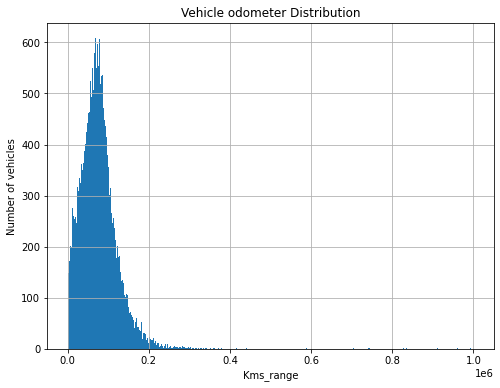

In [293]:
plt.figure(figsize=(8,6))
train.odometer_reading.hist(bins=500)
plt.title('Vehicle odometer Distribution')
plt.xlabel('Kms_range')
plt.ylabel('Number of vehicles')
plt.show()

We have some

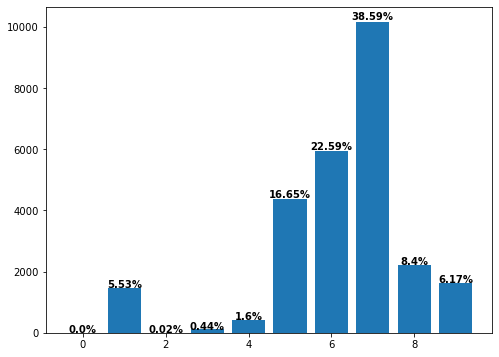

In [51]:
#Class distribution
plt.figure(figsize=(8,6))
perc = y.value_counts(normalize=True)*100
graph = plt.bar(pd.Series(y).value_counts().sort_index().index,pd.Series(y).value_counts().sort_index().values)
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    a, b = p.get_xy()
    plt.text(a+width/2,
             b+height*1.01,
             str(round(perc[i],2))+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

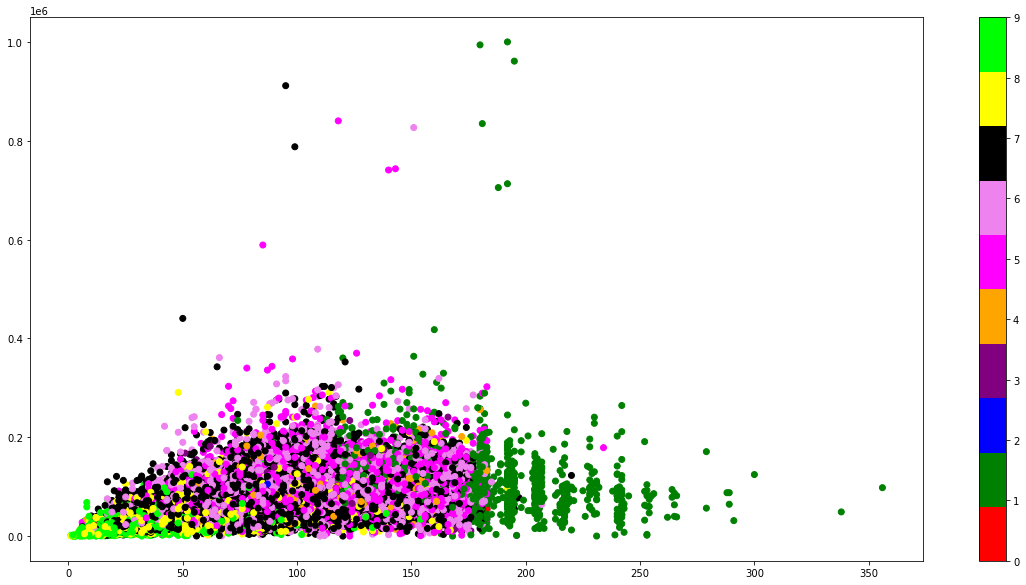

In [75]:
# plotting against important features
import matplotlib
colors = ['red','green','blue','purple','orange','magenta','violet','black','yellow','lime']
fig = plt.figure(figsize=(20,10))
plt.scatter(train['age_at_inspection'], train['odometer_reading'], c= y,marker="o", cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()

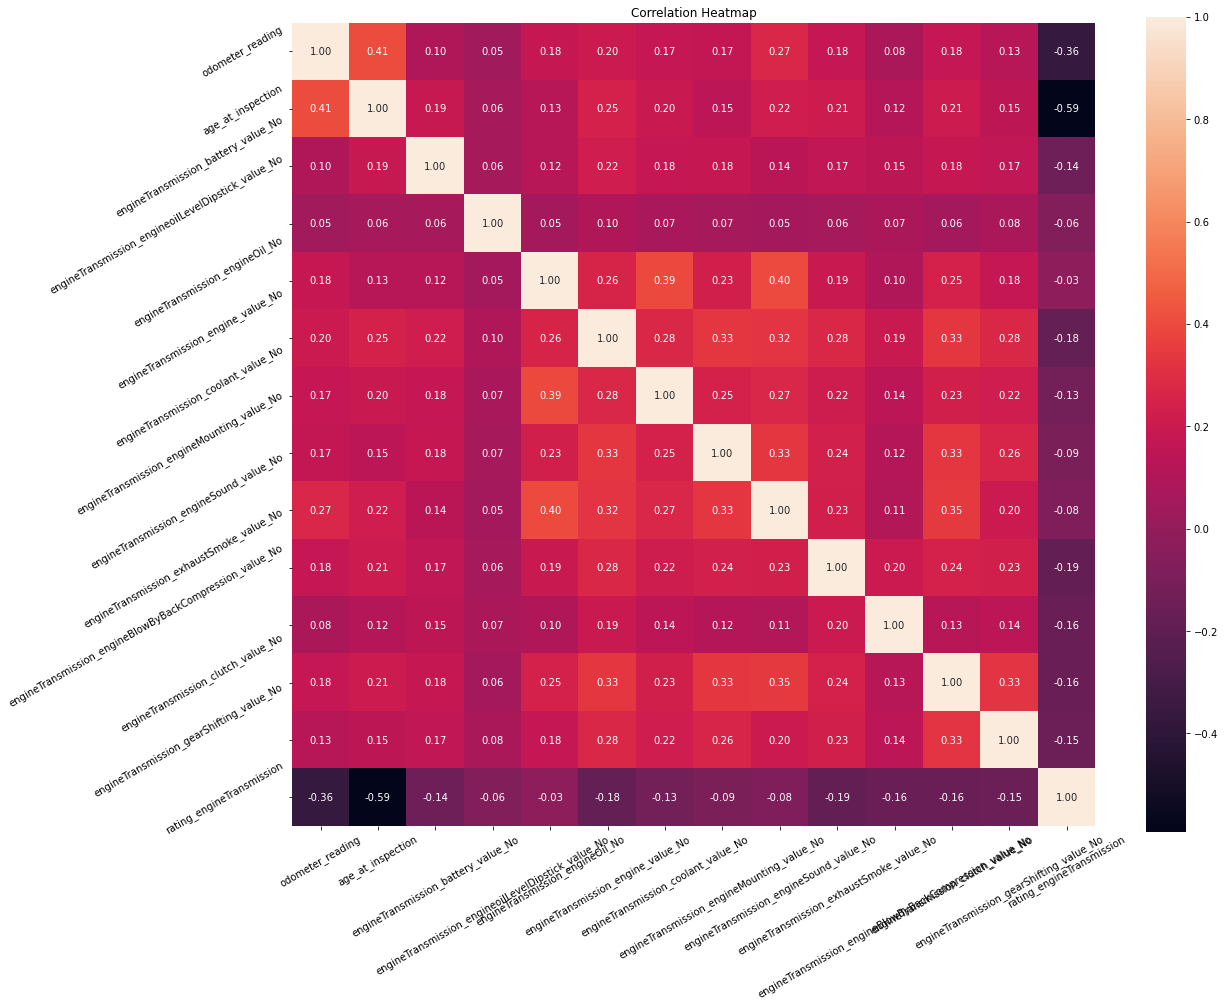

In [24]:
# Create correlation heatmap
corr_matrix = pd.concat([train['odometer_reading'],train['age_at_inspection'],df_engine_flags[[x for x in df_engine_flags.columns if 'No' in x]],y], axis=1).corr()
plt.figure(figsize=(18,15))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()  

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 100)
print(len(X_train), len(y_train))

18405 18405


removing classes with small sample

In [46]:
mask = y_train.isin([0,2,])

X_train = X_train[~mask]
y_train = y_train[~mask]
print(len(X_train), len(y_train),len(X_train.columns),len(X_test),len(y_test))

18399 18399 88 7889 7889


## Model

### Approach-1

In [47]:
lgb_clf = lgb.LGBMClassifier(n_jobs=-1,objective='multiclass',boosting_type ='goss' ,random_state=100)
lgb_clf.fit(X_train, y_train)

print('Training accuracy: ', accuracy_score(y_train, lgb_clf.predict(X_train)))
print('Testing accuracy: ', accuracy_score(y_test, lgb_clf.predict(X_test)))
print('Testing mae: ', mean_absolute_error(y_test, lgb_clf.predict(X_test)))

Training accuracy:  0.6879178216207402
Testing accuracy:  0.5285841044492331
Testing mae:  0.6073013056154138


In [18]:
features_imp = pd.DataFrame()
features_imp['features'] = list(train.columns)[:]
features_imp['importance'] = lgb_clf.feature_importances_
features_imp = features_imp.sort_values(by='importance', ascending=False).reset_index()

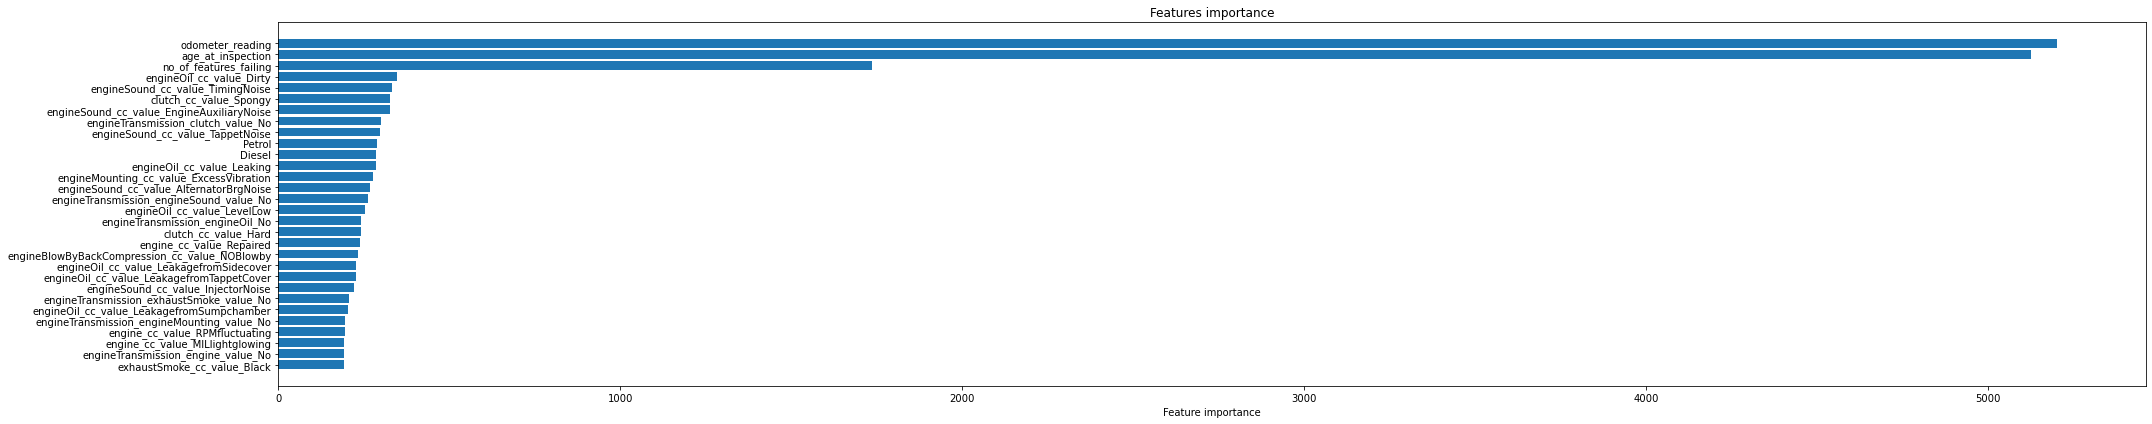

In [19]:
y_plot = -np.arange(30)
plt.figure(figsize=(30,6))
plt.barh(y_plot, features_imp.loc[:29,'importance'].values)
plt.yticks(y_plot,(features_imp.loc[:29,'features']))
plt.xlabel('Feature importance')
plt.title('Features importance')
plt.tight_layout()

error distribution

In [340]:
def central_tendency_plot(point, ci, y, color, label):
    plt.plot(ci, [y, y], "-", color=color, linewidth=4, label=label)
    plt.plot(point, y, "o", color=color, markersize=10)
def plot_error_dist(column):
    d = column.tolist()
    d = [0 if np.math.isnan(x) else x for x in d]
    m = np.mean(d)
    med = np.median(d)
    s = np.std(d)

    x = np.linspace(min(d), max(d), 1000)
    gauss = lambda x, m, s: (1 / (s * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - m) / s) ** 2))
    y = gauss(x, m, s)

    bins = np.arange(min(d), max(d)+1, 1)
    n, b, patches = plt.hist(d, bins=bins+1, density=True, align='left', width=0.95)
    pylab.xticks(bins)
    bin_max = np.max(n)
    m_y = bin_max/5
    
    central_tendency_plot(m, [m - s, m + s], m_y, colors[1], "std dev")

    ci = np.percentile(d, [16, 84])
    central_tendency_plot(med, ci,  m_y - bin_max/10, colors[2], "68% CI")
    
    plt.legend(loc=0)
    plt.plot(x, y, color=colors[4])
    plt.xlabel('Error')
    plt.ylabel('Normalized Frequency')
    title = ' Error Distribution'
    plt.title(title)
    plt.show()

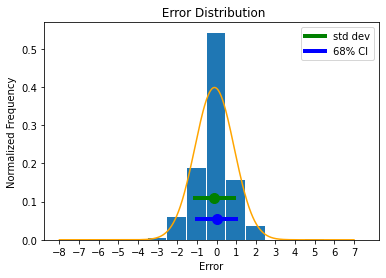

In [343]:
error = y_test - lgb_clf.predict(X_test)
plot_error_dist(error)

In [52]:
y_pred = lgb_clf.predict(X_test)

#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)
print(confusion.diagonal()/confusion.sum(axis=1))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

Confusion Matrix

[[ 417    0    0    1    7    6   10    1    2]
 [   0    0    0    0    1    0    0    0    0]
 [   0    0    0    4   17    5    2    0    0]
 [   0    0    3   11   74   21   14    0    0]
 [  10    0    3   23  545  387  343   14    1]
 [   7    0    0   12  290  612  843   30    7]
 [   3    0    1    7  173  497 2135  147   61]
 [   0    0    0    0    9   29  399  112  128]
 [   0    0    0    0    2    0   61   64  338]]
[0.93918919 0.         0.         0.08943089 0.41101056 0.33981122
 0.70601852 0.16543575 0.72688172]

Classification Report

              precision    recall  f1-score   support

         1.0       0.95      0.94      0.95       444
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00        28
         4.0       0.19      0.09      0.12       123
         5.0       0.49      0.41      0.45      1326
         6.0       0.39      0.34      0.36      1801
         7.0       0.56      0.71      0.63 

D:\Anaconda\Envs\time_series\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Envs\time_series\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Envs\time_series\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Approach-2

In [53]:
### using one vs all approach
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [64]:
lgb_binary = lgb.LGBMClassifier(n_jobs=-1,objective='binary',boosting_type ='goss' ,random_state=100)

clf = OrdinalClassifier(lgb.LGBMClassifier(n_jobs=-1,objective='binary',boosting_type ='goss' ,random_state=100))
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(train_o, y_o, test_size = 0.3, random_state = 100)

clf.fit(X_train_o,y_train_o)

temp = clf.predict(X_test_o)

In [71]:
print('Training accuracy: ', accuracy_score(y_train_o, clf.predict(X_train_o)))
print('Testing accuracy: ', accuracy_score(y_test_o, temp))
print('Testing mae: ', mean_absolute_error(y_test_o, temp))
confusion_matrix(y_test_o, temp)


Training accuracy:  0.6711741066579776
Testing accuracy:  0.5399721272013176
Testing mae:  0.5893829975928038


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  408,    1,    0,    0,    6,    7,    5,    2,    0],
       [   0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    8,   28,    3,    2,    0,    0],
       [   0,    0,    0,    1,   12,   73,   20,   13,    0,    0],
       [   1,    7,    1,    4,   18,  560,  354,  360,    5,    0],
       [   1,    7,    0,    1,    6,  327,  588,  815,   15,    2],
       [   1,    8,    0,    0,    2,  147,  487, 2171,  148,   76],
       [   0,    0,    0,    0,    0,    6,   38,  382,  104,  126],
       [   0,    1,    0,    0,    0,    1,    1,   55,   58,  418]],
      dtype=int64)

### nearest - neigbours

In [72]:
## nearest neighbour analysis
from sklearn import neighbors
model_knn = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
model_knn.fit(train)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [73]:
neighbors = np.asarray(model_knn.kneighbors(train, return_distance=False))
from statistics import mode

In [83]:
df.iloc[neighbors[2][0:]]['rating_engineTransmission']

2        3.5
20059    3.5
23427    3.5
4229     4.0
18311    4.0
7428     3.5
22000    3.5
24274    3.5
11027    3.0
14795    3.5
Name: rating_engineTransmission, dtype: float64